In [ ]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

# Part 1 : Halo Extraction

### The file contains multiple columns with various values that are listed as follows to create a Pandas DataFrame

In [ ]:
columns = [
    'scale', 'id', 'desc_scale', 'desc_id', 'num_prog', 'pid', 'upid', 'desc_pid',
    'phantom', 'sam_Mvir', 'Mvir', 'Rvir', 'rs', 'vrms', 'mmp?', 'scale_of_last_MM',
    'vmax', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Jx', 'Jy', 'Jz', 'Spin',
    'Breadth_first_ID', 'Depth_first_ID', 'Tree_root_ID', 'Orig_halo_ID', 'Snap_idx',
    'Next_coprogenitor_depthfirst_ID', 'Last_progenitor_depthfirst_ID',
    'Last_mainleaf_depthfirst_ID', 'Tidal_Force', 'Tidal_ID', 'Rs_Klypin', 'Mvir_all',
    'M200b', 'M200c', 'M500c', 'M2500c', 'Xoff', 'Voff', 'Spin_Bullock', 'b_to_a',
    'c_to_a', 'A[x]', 'A[y]', 'A[z]', 'b_to_a_500c', 'c_to_a_500c', 'A[x]_500c',
    'A[y]_500c', 'A[z]_500c', 'T_U_ratio', 'M_pe_Behroozi', 'M_pe_Diemer', 'Halfmass_Radius',
    'Macc', 'Mpeak', 'Vacc', 'Vpeak', 'Halfmass_Scale', 'Acc_Rate_Inst',
    'Acc_Rate_100Myr', 'Acc_Rate_1_Tdyn', 'Acc_Rate_2_Tdyn', 'Acc_Rate_Mpeak',
    'Acc_Log_Vmax_Inst', 'Acc_Log_Vmax_1_Tdyn', 'Mpeak_Scale', 'Acc_Scale', 'First_Acc_Scale',
    'First_Acc_Mvir', 'First_Acc_Vmax', 'Vmax_at_Mpeak', 'Tidal_Force_Tdyn',
    'Log_Vmax_Vmaxmax_Tdyn_Tmpeak', 'Time_to_future_merger', 'Future_merger_MMP_ID',
    'Spin_at_Mpeak_Scale'
]

# Read the file, skip comment lines starting with '#'
df = pd.read_csv('out_200.trees', comment='#', delim_whitespace=True, header=None, names=columns)

print(df.head())

/tmp/ipython-input-64-1178239021.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('out_200.trees', comment='#', delim_whitespace=True, header=None, names=columns)


   scale       id  desc_scale  desc_id  num_prog  pid  upid  desc_pid  \
0    1.0  6232111         0.0       -1         2   -1    -1        -1   
1    1.0  6227163         0.0       -1         1   -1    -1        -1   
2    1.0  6216872         0.0       -1         1   -1    -1        -1   
3    1.0  6209338         0.0       -1         1   -1    -1        -1   
4    1.0  6232128         0.0       -1         1   -1    -1        -1   

   phantom      sam_Mvir  ...  Acc_Scale  First_Acc_Scale  First_Acc_Mvir  \
0        0  9.248530e+14  ...        1.0              1.0    9.243000e+14   
1        0  6.868000e+14  ...        1.0              1.0    6.868000e+14   
2        0  6.476000e+14  ...        1.0              1.0    6.476000e+14   
3        0  6.224000e+14  ...        1.0              1.0    5.866000e+14   
4        0  5.585000e+14  ...        1.0              1.0    5.585000e+14   

   First_Acc_Vmax  Vmax_at_Mpeak  Tidal_Force_Tdyn  \
0         1535.53        1510.50            

### Creating a mass threshold equal to 1e14 to filter all the halos present in the file according to their mass.
### Since only the ones with sufficient points will have such a high mass, we want only those.

In [ ]:
#To consider only those halos above this mass threshold
mass_threshold = 1e14
mass_lower = 1e12
# Filter the halos
filtered_df = df[(df['Mvir'] > mass_lower) & (df['Mvir'] < mass_threshold)]


# Select x, y, z and vx, vy, vz columns
result = filtered_df[['Mvir','Rvir', 'x', 'y', 'z', 'vx', 'vy', 'vz']]

# Print the first few rows
print(result)

               Mvir     Rvir          x          y          z      vx      vy  \
226    9.972000e+13  940.799  155.18636   88.23442  102.06087  259.15  -91.52   
227    9.935000e+13  939.623  152.36852   98.92574  134.06863  521.49 -277.87   
228    9.910000e+13  938.837   47.63109  142.11902  129.32935 -261.22  109.34   
229    9.852000e+13  936.998  186.52174   10.36842  166.14015  423.56  116.80   
230    9.806000e+13  935.548   21.51634   18.23485   38.74427  300.42   76.73   
...             ...      ...        ...        ...        ...     ...     ...   
32971  1.038000e+12  205.409  117.80093  176.98390  150.92332  -60.37 -341.11   
32972  1.038000e+12  205.409  142.36279  139.68010  161.40294 -113.91  -70.08   
32973  1.038000e+12  205.409  137.01648  131.74231  151.78754  155.79  215.92   
32974  1.038000e+12  205.409  125.90292  150.18503  151.82466   65.99  -21.15   
32975  1.038000e+12  205.409  114.78288  149.71101  157.53745  242.59  323.39   

           vz  
226     70.

#Part 2 : Determining Points inside Halo

###Loading the file using h5py and displaying the headers

In [ ]:
filename = 'snapshot_200.hdf5'

with h5py.File(filename, 'r') as f:
    # Print top-level keys again
    print("Top-level keys:", list(f.keys()))

    #PartType 1 key config
    parttype1 = f['PartType1']
    print("PartType1 keys:", list(parttype1.keys()))

Top-level keys: ['Config', 'Header', 'Parameters', 'PartType1']
PartType1 keys: ['Acceleration', 'Coordinates', 'ParticleIDs', 'Potential', 'Velocities']


###Choose a halo from part 1 and use its centre, radius and velocity

In [ ]:
center = np.array([47.63109, 142.11902, 129.32935])
radius = 938.837 / 1000     #radius = Rvir/1000 to convert from kpc to Mpc
vel = np.array([-261.22, 109.34, 166.90])

###Determine the distance of each point in the simulation from the centre of the halo by calculating the norm of the vector.

In [ ]:
with h5py.File('snapshot_200.hdf5', 'r') as f:
    coords = f['PartType1/Coordinates'][:] # shape (N, 3)
    vels   = f['PartType1/Velocities'][:]    # shape (N, 3)
center = center
distances = np.linalg.norm(coords - center, axis=1)

###Using a mask to filter the points that lie within the virial radius of the halo.

In [ ]:
# Create a mask for particles within the desired radius
mask = distances <= radius

# Apply mask to get filtered coordinates and velocities
filtered_coords = coords[mask]
filtered_vels   = vels[mask]

filtered_vels = filtered_vels - vel

# Optional: print number of particles found
print(f"Number of particles within radius: {filtered_coords.shape[0]}")

# Example: first 5 positions and velocities
print("First 5 positions:")
print(filtered_coords[:5])
print("First 5 velocities:")
print(filtered_vels[:5])

Number of particles within radius: 2387
First 5 positions:
[[ 48.525585 142.30905  129.3277  ]
 [ 48.48699  142.30016  129.4742  ]
 [ 48.44467  142.22424  129.3198  ]
 [ 48.46422  142.27129  129.12805 ]
 [ 48.474854 141.75894  129.14828 ]]
First 5 velocities:
[[ 710.6363208   216.63821045  711.64046631]
 [-300.51730469  -27.45117554  451.56691895]
 [ 249.91001198 -241.68300232  182.68724976]
 [-148.35614136    6.66956726  505.5418335 ]
 [-120.59625366  270.11019531  130.30806885]]


#Part 3 : Density Calculation

###Assuming a particular mass of each point and creating the bins for density calculation

In [ ]:
m_particle = 4.15153252e10  # Msun/h, replace with actual mass if known

#Density profile parameters
r_min = 1e-2  # Mpc/h
r_max = radius
n_bins = 30
bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)

#Histogram of particle counts in radial shells
counts, _, _ = binned_statistic(distances[mask], distances[mask], statistic='count', bins=bins)

###Calculating volume and density of each concentric shell.:

In [ ]:
#Volume of each spherical shell
volumes = (4/3) * np.pi * (bins[1:]**3 - bins[:-1]**3)

#Compute mass and density in each shell
mass_shells = counts * m_particle
density = mass_shells / volumes

###Plot of the density in log with respect to the radius.

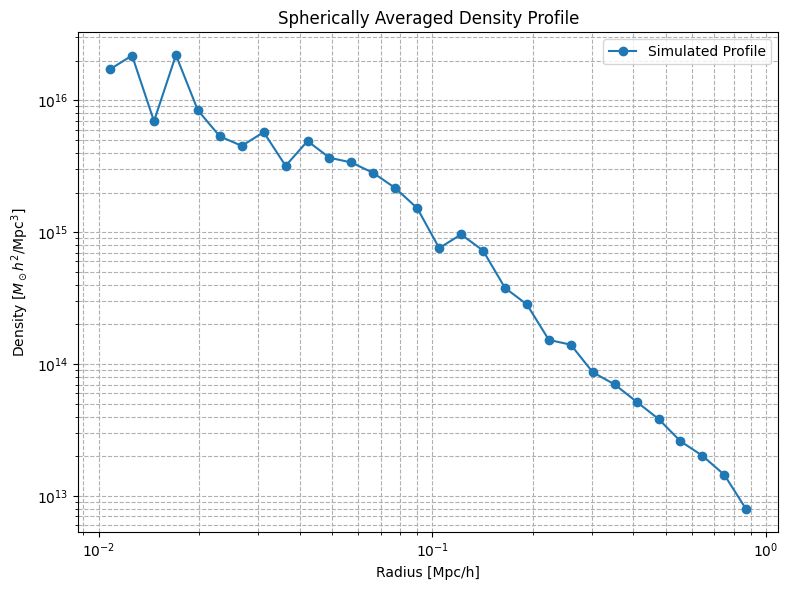

In [ ]:
#Midpoint radii for plotting
r_mid = 0.5 * (bins[1:] + bins[:-1])

#Plot the density profile
plt.figure(figsize=(8,6))
plt.plot(r_mid, density, marker='o', label='Simulated Profile')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius [Mpc/h]')
plt.ylabel('Density [$M_\\odot h^2/\\mathrm{Mpc}^3$]')
plt.title('Spherically Averaged Density Profile')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

#Part 4 : Fitting to NFW Plot

###Defining the function for NFW profile in log because the fitting function cannot handle extremely large values relevant to us

In [ ]:
def log_nfw(r, log_rho_s, r_s):
    rho_s = 10.0**log_rho_s
    return np.log10(rho_s / ((r / r_s) * (1 + r / r_s)**2))

###Converting density to log and fitting it with an initial guess of [10, -1] as rho_s and r_s respectively

In [ ]:
# Compute log-density safely by filtering invalid points
valid = (density > 0) & np.isfinite(density)

# Apply mask to both radius and density arrays
r_mid_valid = r_mid[valid]
log_density = np.log10(density[valid])

# Fit the log NFW function
popt, _ = curve_fit(log_nfw, r_mid_valid, log_density, p0=[10, 0.1])

# Extract fit parameters
log_rho_s_fit, r_s_fit = popt
rho_s_fit = 10**log_rho_s_fit

# Print the result
print(f"Best-fit rho_s = {rho_s_fit:.3e} Msun/h / Mpc^3")
print(f"Best-fit r_s   = {r_s_fit:.3f} Mpc/h")


Best-fit rho_s = 1.314e+15 Msun/h / Mpc^3
Best-fit r_s   = 0.183 Mpc/h


###Plotting the data fitted to an NFW Profile

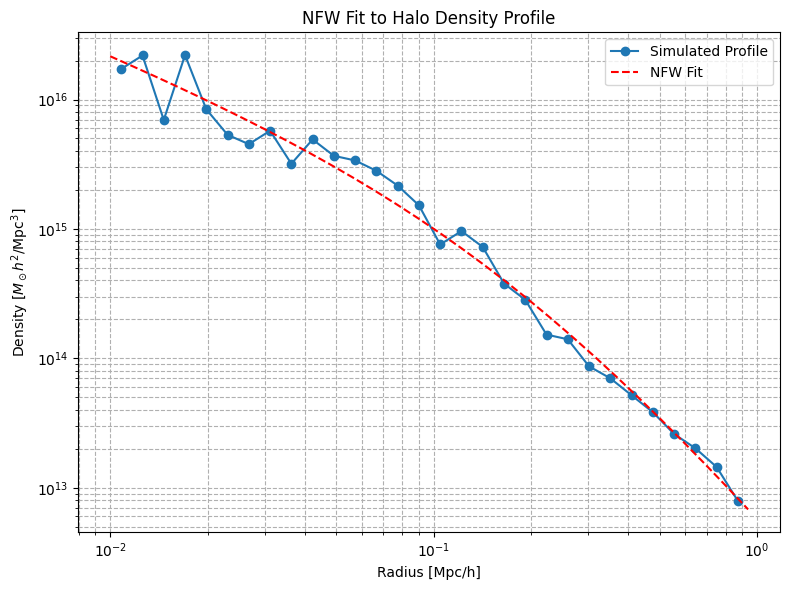

In [ ]:
r_fit = np.logspace(np.log10(r_min), np.log10(r_max), 30)
density_fit = rho_s_fit / ((r_fit / r_s_fit) * (1 + r_fit / r_s_fit)**2)

plt.figure(figsize=(8, 6))
plt.plot(r_mid, density, 'o', linestyle = '-', label='Simulated Profile')
plt.plot(r_fit, density_fit, 'r--', label='NFW Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius [Mpc/h]')
plt.ylabel(r'Density [$M_\odot h^2 / \mathrm{Mpc}^3$]')
plt.title('NFW Fit to Halo Density Profile')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()


#Part 5 : Overdensity Calculation

###Calculation for the Critical Mass Density at z=0 because that is what the simulation runs at

In [ ]:
# Cosmological parameters
H0 = 100  # Hubble parameter in h km/s/Mpc (for h = 1 units)
G = 4.30091e-9  # Newton's constant in (Mpc/h) (km/s)^2 / (Msun/h)
Omega_m = 0.3  # Matter density parameter

# Critical density: rho_crit = 3 H^2 / (8 pi G)
rho_crit = 3 * (H0**2) / (8 * np.pi * G)  # Units: Msun/h / (Mpc/h)^3

# Mean matter density
background_density = Omega_m * rho_crit  # Units: Msun/h / (Mpc/h)^3

print(f"Critical Density: {rho_crit:.3e} Msun/h / (Mpc/h)^3")
print(f"Mean Matter Density: {background_density:.3e} Msun/h / (Mpc/h)^3")

Critical Density: 2.775e+11 Msun/h / (Mpc/h)^3
Mean Matter Density: 8.326e+10 Msun/h / (Mpc/h)^3


In [ ]:
# Compute overdensity contrast δ = (rho - rho_m) / rho_m
delta = density / background_density - 1


###Plot for overdensity

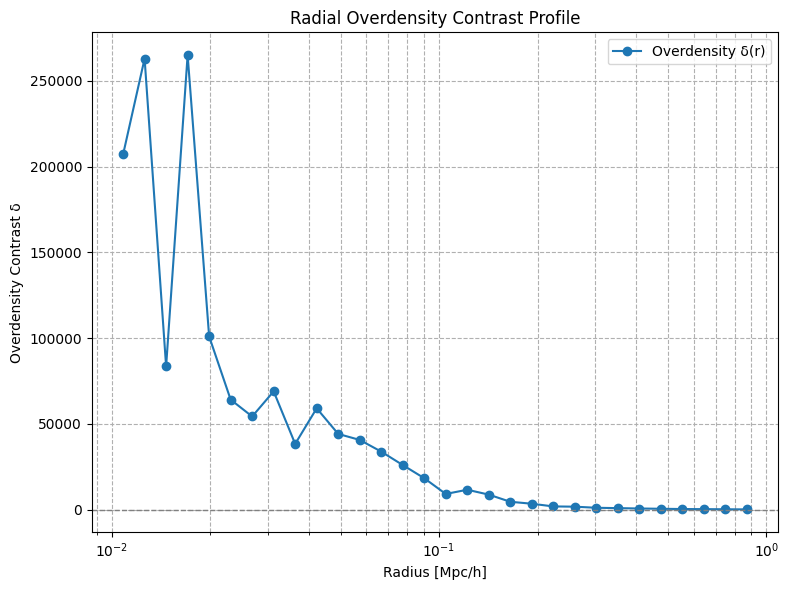

[207045.88179737 262928.71472576  83472.89041269 265008.62007648
 100960.05268731]


In [ ]:
plt.figure(figsize=(8,6))
plt.plot(r_mid, delta, marker='o', label='Overdensity δ(r)')
plt.xscale('log')
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.xlabel('Radius [Mpc/h]')
plt.ylabel('Overdensity Contrast δ')
plt.title('Radial Overdensity Contrast Profile')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()

print(delta[:5])

[207045.88179737 262928.71472576  83472.89041269 265008.62007648
 100960.05268731]


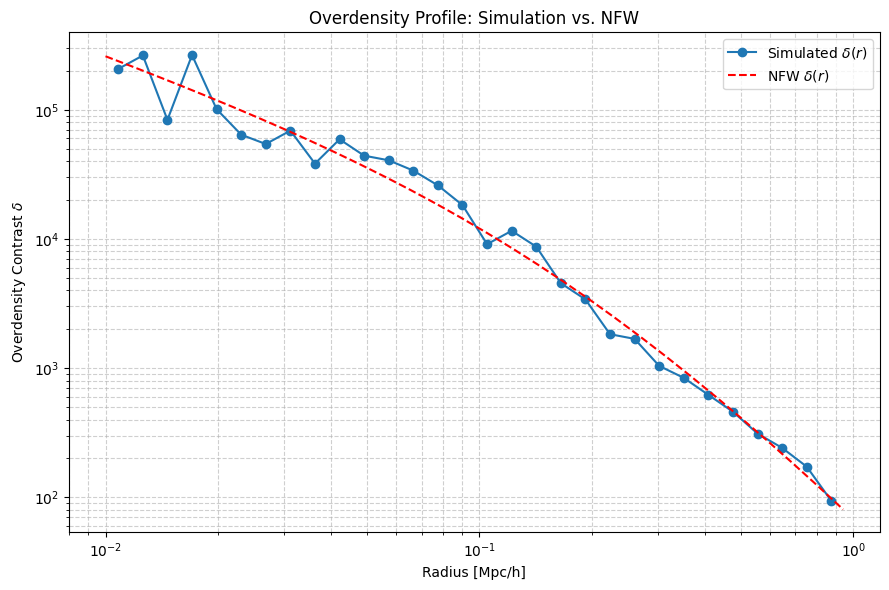

In [ ]:
#Calculating the NFW Overdensity Profile
delta_nfw = (density_fit - background_density) / background_density
print(delta[:5])
#Plotting both of them together
plt.figure(figsize=(9, 6))
plt.plot(r_mid, delta, 'o-', label='Simulated $\\delta(r)$')
plt.plot(r_fit, delta_nfw, 'r--', label='NFW $\\delta(r)$')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius [Mpc/h]')
plt.ylabel('Overdensity Contrast $\\delta$')
plt.title('Overdensity Profile: Simulation vs. NFW')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


#Part 6 : Velocity Calculation

###Computing the three components of average velocity for each shell

In [ ]:
# Extract velocity components
vx = filtered_vels[:, 0]
vy = filtered_vels[:, 1]
vz = filtered_vels[:, 2]

# Compute average velocity in each radial bin
vx_avg, _, _ = binned_statistic(distances[mask], vx, statistic='mean', bins=bins)
vy_avg, _, _ = binned_statistic(distances[mask], vy, statistic='mean', bins=bins)
vz_avg, _, _ = binned_statistic(distances[mask], vz, statistic='mean', bins=bins)

###Plotting the 3 averaged velocities with respect to shell radius

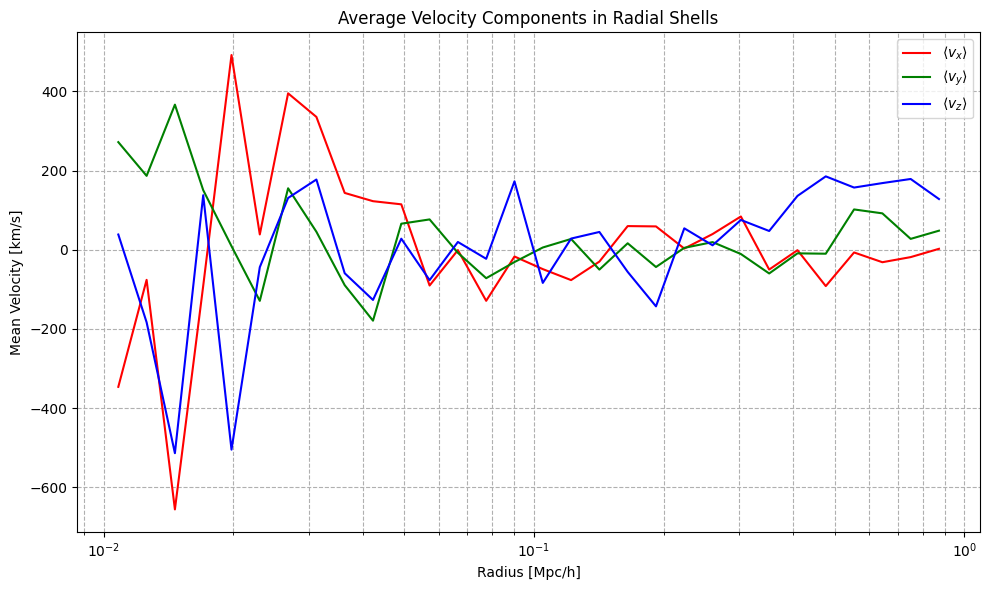

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(r_mid, vx_avg, 'r-', label=r'$\langle v_x \rangle$')
plt.plot(r_mid, vy_avg, 'g-', label=r'$\langle v_y \rangle$')
plt.plot(r_mid, vz_avg, 'b-', label=r'$\langle v_z \rangle$')
plt.xscale('log')
plt.xlabel('Radius [Mpc/h]')
plt.ylabel('Mean Velocity [km/s]')
plt.title('Average Velocity Components in Radial Shells')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()


###Calculating Polar Coordinates of each point

In [ ]:
# Relative positions and velocities (already defined)
x, y, z = filtered_coords[:, 0] - center[0], filtered_coords[:, 1] - center[1], filtered_coords[:, 2] - center[2]
vx, vy, vz = filtered_vels[:, 0], filtered_vels[:, 1], filtered_vels[:, 2]

#Compute spherical coordinates
r     = np.sqrt(x**2 + y**2 + z**2)
theta = np.arccos(z / r)                  # polar angle
phi   = np.arctan2(y, x)                  # azimuthal angle

###Computing the Unit Vectors for the conversion

In [ ]:
# Step 2: Compute unit vectors for spherical basis
sin_theta = np.sin(theta)
cos_theta = np.cos(theta)
sin_phi   = np.sin(phi)
cos_phi   = np.cos(phi)

# Unit vectors
r_hat = np.stack([sin_theta * cos_phi,
                  sin_theta * sin_phi,
                  cos_theta], axis=1)

theta_hat = np.stack([cos_theta * cos_phi,
                      cos_theta * sin_phi,
                     -sin_theta], axis=1)

phi_hat = np.stack([-sin_phi,
                     cos_phi,
                     np.zeros_like(phi)], axis=1)

###Expressing velocities in Polar Frame

In [ ]:
# Stack velocities
v = np.stack([vx, vy, vz], axis=1)

# Step 3: Project velocities onto spherical basis
v_r     = np.sum(v * r_hat, axis=1)
v_theta = np.sum(v * theta_hat, axis=1)
v_phi   = np.sum(v * phi_hat, axis=1)

###Calculating the average values for the velocities in each shell

In [ ]:
# Same bins as your density profile
bins = np.logspace(np.log10(r_min), np.log10(r_max), n_bins + 1)
r_mid = 0.5 * (bins[1:] + bins[:-1])

# Average velocity components in each shell
v_r_avg, _, _     = binned_statistic(distances[mask], np.abs(v_r), statistic='mean', bins=bins)
v_theta_avg, _, _ = binned_statistic(distances[mask], np.abs(v_theta), statistic='mean', bins=bins)
v_phi_avg, _, _   = binned_statistic(distances[mask], np.abs(v_phi), statistic='mean', bins=bins)


###Final Plot of the velocities

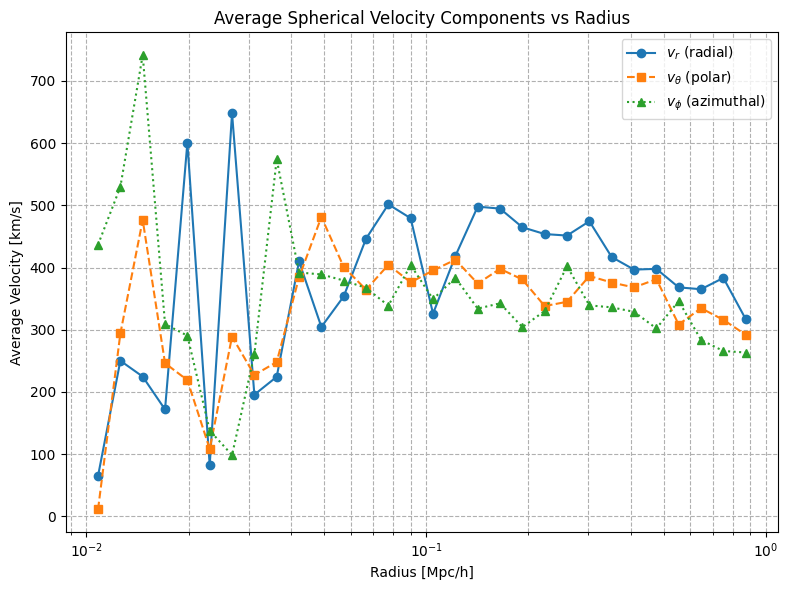

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(r_mid, v_r_avg, 'o-', label=r'$v_r$ (radial)')
plt.plot(r_mid, v_theta_avg, 's--', label=r'$v_\theta$ (polar)')
plt.plot(r_mid, v_phi_avg, '^:', label=r'$v_\phi$ (azimuthal)')

plt.xscale('log')
plt.xlabel('Radius [Mpc/h]')
plt.ylabel('Average Velocity [km/s]')
plt.title('Average Spherical Velocity Components vs Radius')
plt.grid(True, which='both', ls='--')
plt.legend()
plt.tight_layout()
plt.show()
